In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm as tqdm

In [2]:
"""
MONTH - a month claims were lodged
SERVICE_CATEGORY - a department that provided services to patients
CLAIM_SPECIALTY - a type of medical services by an official classification system
PAYER - an insurance company
PAID_AMOUNT - sum of expenses (claims), $
"""

def wrangle(path):
    '''
    Function created after data exploration and 
    data quality analysis in each column.

    I saved PCPEncounter with only 42 observation because 
    it has can enough data for analysis
    '''
    
    df = pd.read_csv(path)
    
    # drop bad date and rare date in column 'MONTH'
    mask1 = df['MONTH'] != 201900
    mask2 = df['MONTH'] != 202007
    df = df[mask1 & mask2]
    
    # date to datetime
    df['date'] = pd.to_datetime(df['MONTH'], format='%Y%m') # , errors='coerce'
    
    # replace the same service category
    df['SERVICE_CATEGORY'] = df['SERVICE_CATEGORY'].replace("SpecialistsFFS",'SpecialistFFS')    
    
    # drop NaN CLAIM_SPECIALTY
    df.dropna(subset=['CLAIM_SPECIALTY'], inplace=True)
    
    # choose only one type of payments
    df = df[df.PAID_AMOUNT > 0]
    df['PAID_AMOUNT'] = df['PAID_AMOUNT'].astype('int64')
    
    # choose payments between quantiles without outliers
    q1, q9 = df.PAID_AMOUNT.quantile([0.01, 0.99])
    df = df[df.PAID_AMOUNT.between(q1,q9)]
    
    # add season and month as a category
    df['month'] = df['date'].dt.month.astype(str)
                   
    df['SEASON'] = (df['date'].dt.month
                   .astype(str)
                   .replace(['12','1','2'],'winter')
                   .replace(['3','4','5'],'spring')
                   .replace(['6','7','8'],'summer')
                   .replace(['9','10','11'],'autumn')
                   )  
    
    print('q1:', round(q1), 'q9:', round(q9))
    print()
    print('isna_sum:', df.isna().mean().sum())
    print()
    print('df_shape is: ', df.shape)
    
    print(df.dtypes)
    
    return df
    
path = "claims_sample_data.csv"

df = wrangle(path)
df.head(5)

q1: 14 q9: 54388

isna_sum: 0.0

df_shape is:  (46734, 8)
MONTH                        int64
SERVICE_CATEGORY            object
CLAIM_SPECIALTY             object
PAYER                       object
PAID_AMOUNT                  int64
date                datetime64[ns]
month                       object
SEASON                      object
dtype: object


,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,date,month,SEASON
4,201801,AncillaryFFS,ACH,Payer W,151,2018-01-01,1,winter
6,201801,AncillaryFFS,ADVANCED RN PRACT,Payer CA,443,2018-01-01,1,winter
7,201801,AncillaryFFS,AMBULANCE,Payer CA,14890,2018-01-01,1,winter
8,201801,AncillaryFFS,AMBULANCE,Payer CO,1722,2018-01-01,1,winter
9,201801,AncillaryFFS,AMBULANCE,Payer F,36108,2018-01-01,1,winter


In [3]:
df['date'].agg(['min', 'max'])

min   2018-01-01
max   2020-06-01
Name: date, dtype: datetime64[ns]

<AxesSubplot:xlabel='date'>

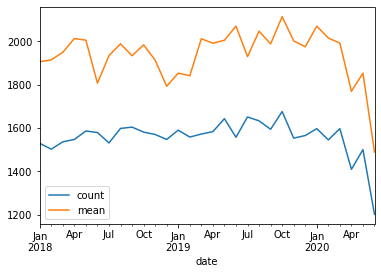

In [4]:
df.groupby('date')['PAID_AMOUNT'].agg(['count', 'mean']).plot()

In [5]:
(df.groupby(['CLAIM_SPECIALTY'])['PAID_AMOUNT']
 .agg(['count', 'mean', 'sum'])
 .sort_values(by='count', ascending=False)
)

,count,mean,sum
CLAIM_SPECIALTY,,,
INTERNAL MEDICINE,1084,3990.092251,4325260
FAMILY PRACTICE,998,1869.682365,1865943
GENERAL SURGERY,798,1869.350877,1491742
GENERAL PRACTICE,777,1263.491634,981733
RADIOLOGY,749,3570.702270,2674456
...,...,...,...
Neuropsychology,1,224.000000,224
SPHEAR,1,155.000000,155
Neonatology,1,606.000000,606


In [6]:
# Select features with enought data
top_specialty = (df.groupby('CLAIM_SPECIALTY')['PAID_AMOUNT']
             .agg(['count','mean'])
             .sort_values(by='count', ascending=False)
            )
top_specialty = top_specialty[top_specialty['count'] > 10]
print(len(top_specialty))
top_specialty

450


,count,mean
CLAIM_SPECIALTY,,
INTERNAL MEDICINE,1084,3990.092251
FAMILY PRACTICE,998,1869.682365
GENERAL SURGERY,798,1869.350877
GENERAL PRACTICE,777,1263.491634
RADIOLOGY,749,3570.702270
...,...,...
Internal Medicine - Infectious Disease\t,11,533.909091
TRAUMA SURGERY,11,469.090909
PERSONAL EMERGENCY RESPONSE SYSTEM,11,42.272727


# Model

In [7]:
df.columns

Index(['MONTH', 'SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER', 'PAID_AMOUNT',
       'date', 'month', 'SEASON'],
      dtype='object')

In [8]:
# Create the feature matrix and the target vector
features = ['SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER', 'SEASON']
target = "PAID_AMOUNT"

train = df.sample(frac=0.7,random_state=42).copy()
val = df[~df.index.isin(train.index)].copy()

In [14]:
# Baseline model
y_mean = train['PAID_AMOUNT'].mean()
y_pred_baseline = [y_mean] * len(train)
mae_baseline = mean_absolute_error(train[target], y_pred_baseline)

print("Mean payment:", round(y_mean))
print("Baseline MAE:", round(mae_baseline))

Mean payment: 1934
Baseline MAE: 2097


In [15]:
# CatBoostRegressor
model_1 = CatBoostRegressor(verbose=100, 
                          eval_metric='RMSE',
                          random_state=42
                         )

model_1.fit(train[features], train[target],
          cat_features=features,
          eval_set=(val[features],val[target])
         )

y_pred_training = model_1.predict(val[features])
print("Training MAE:", mean_absolute_error(val[target], y_pred_training))

Learning rate set to 0.088046
0:	learn: 4711.7007232	test: 4803.0938571	best: 4803.0938571 (0)	total: 72.5ms	remaining: 1m 12s
100:	learn: 2895.9410102	test: 2554.7146897	best: 2554.7146897 (100)	total: 531ms	remaining: 4.73s
200:	learn: 2631.2744275	test: 2324.0269451	best: 2323.7947078 (199)	total: 965ms	remaining: 3.84s
300:	learn: 2515.6803277	test: 2233.2157887	best: 2233.2157887 (300)	total: 1.47s	remaining: 3.42s
400:	learn: 2458.2302201	test: 2198.8000955	best: 2198.7682659 (398)	total: 1.92s	remaining: 2.87s
500:	learn: 2391.6878836	test: 2161.9745591	best: 2161.9745591 (500)	total: 2.37s	remaining: 2.36s
600:	learn: 2327.3518973	test: 2132.2744275	best: 2132.1788137 (597)	total: 2.84s	remaining: 1.89s
700:	learn: 2285.3408865	test: 2119.0970351	best: 2118.3639517 (693)	total: 3.29s	remaining: 1.4s
800:	learn: 2236.5959963	test: 2101.4476356	best: 2100.6166834 (794)	total: 3.74s	remaining: 930ms
900:	learn: 2201.0000856	test: 2097.0532561	best: 2097.0532561 (900)	total: 4.2s	r

## MAE is reduced, so the model can be exist and has explanation power

In [16]:
# power of each feature
fi = pd.DataFrame({'feature':features,'fi':model_1.feature_importances_})
fi = fi.sort_values('fi',ascending=False)
fi

,feature,fi
1,CLAIM_SPECIALTY,40.092075
0,SERVICE_CATEGORY,29.531623
2,PAYER,28.356384
3,SEASON,2.019918


In [ ]:
# season is not very important but it is improving the model

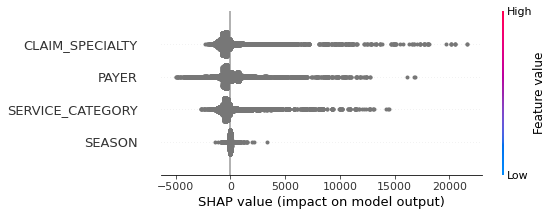

In [17]:
# shap plotting
explainer = shap.Explainer(model_1)
shap_values = explainer(val[features])

shap.summary_plot(shap_values,
                 val[features],
                 max_display = 50)

# Boostrap model

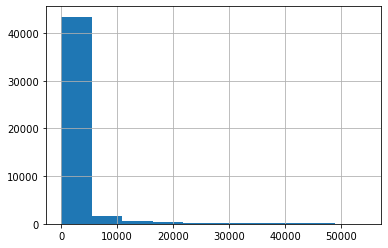

In [18]:
# The data don't have normal distribution
df['PAID_AMOUNT'].hist();

  0%|          | 0/10000 [00:00<?, ?it/s]

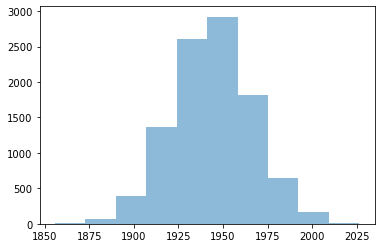

In [19]:
# boostrap all data set
my_samples = []

for _ in tqdm(range(10000)):
    x = np.random.choice(df['PAID_AMOUNT'], size=round(len(df['PAID_AMOUNT'])), replace=True)
    my_samples.append(x.mean())
    
plt.hist(my_samples, alpha=0.5);

In [20]:
# create diction from unique features for loop 
df_top = df[df['CLAIM_SPECIALTY'].isin(top_specialty.index)]
df_top = df_top[['SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER']].drop_duplicates()
dict_ = df_top.T.to_dict()

In [21]:
# boostrap features in df
my_lst = []

for k,v in tqdm(dict_.items()):
    lst = []
    for i,j in v.items():
        lst.append(j)
        
    t = (df[ (df['SERVICE_CATEGORY'] == lst[0]) & 
             (df['CLAIM_SPECIALTY'] == lst[1]) & 
             (df['PAYER'] == lst[2])]
        )   
    
    for _ in range(5000):
        x = np.random.choice(t['PAID_AMOUNT'], size=round(len(t['PAID_AMOUNT'])), replace=True)
        my_lst.append([lst[0], lst[1], lst[2], x.mean()])

  0%|          | 0/3213 [00:00<?, ?it/s]

In [22]:
# Create df after boostrap
my_df = pd.DataFrame(my_lst, columns=['SERVICE_CATEGORY','CLAIM_SPECIALTY','PAYER','PAID_AMOUNT'])
print(len(my_df))
my_df.head()

16065000


,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,AncillaryFFS,ADVANCED RN PRACT,Payer CA,401.500000
1,AncillaryFFS,ADVANCED RN PRACT,Payer CA,540.071429
2,AncillaryFFS,ADVANCED RN PRACT,Payer CA,551.500000
3,AncillaryFFS,ADVANCED RN PRACT,Payer CA,499.392857
4,AncillaryFFS,ADVANCED RN PRACT,Payer CA,659.821429


<AxesSubplot:>

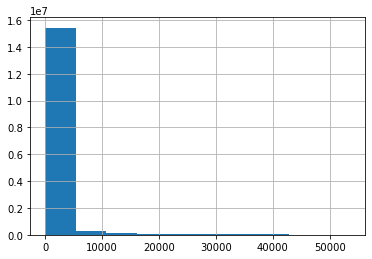

In [23]:
my_df.PAID_AMOUNT.hist()

29


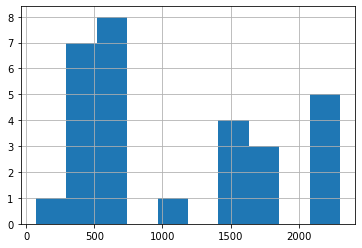

In [24]:
# example before boostrap
t = (df[(df['SERVICE_CATEGORY'] == 'AncillaryFFS') &
           (df['CLAIM_SPECIALTY'] == 'AMBULATORY SURGICAL CENTER') &
           (df['PAYER'] == 'Payer W')]
    )
print(len(t))
t.PAID_AMOUNT.hist();

5000


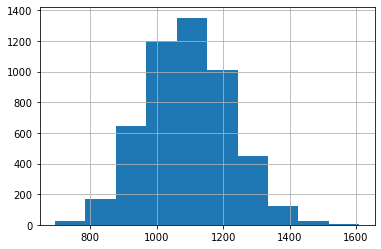

In [25]:
# example after boostrap
t = (my_df[(my_df['SERVICE_CATEGORY'] == 'AncillaryFFS') &
           (my_df['CLAIM_SPECIALTY'] == 'AMBULATORY SURGICAL CENTER') &
           (my_df['PAYER'] == 'Payer W')]
    )
print(len(t))
t.PAID_AMOUNT.hist();

In [26]:
# New train, val for boostrap model
features = ['SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER']
target = "PAID_AMOUNT"

train = my_df.sample(frac=0.7,random_state=42).copy()
val = my_df[~my_df.index.isin(train.index)].copy()
print(len(train), len(val))

11245500 4819500


In [27]:
# CatBoostRegressor
model_2 = CatBoostRegressor(verbose=100, 
                          eval_metric='RMSE',
                          random_state=42
                         )

model_2.fit(train[features], train[target],
          cat_features=features,
          eval_set=(val[features],val[target])
         )

y_pred_training = model_2.predict(val[features])
print("Training MAE:", mean_absolute_error(val[target], y_pred_training))

Learning rate set to 0.220242
0:	learn: 3642.4268350	test: 3647.9134045	best: 3647.9134045 (0)	total: 4.21s	remaining: 1h 10m 6s
100:	learn: 1229.6401461	test: 1192.4319491	best: 1192.4319491 (100)	total: 3m 29s	remaining: 31m 7s
200:	learn: 835.1555469	test: 782.8060291	best: 782.8060291 (200)	total: 6m 41s	remaining: 26m 37s
300:	learn: 664.4087284	test: 606.3738540	best: 606.3738540 (300)	total: 10m 6s	remaining: 23m 29s
400:	learn: 581.0775161	test: 520.7835531	best: 520.7835531 (400)	total: 13m 19s	remaining: 19m 53s
500:	learn: 528.2663841	test: 465.3603845	best: 465.3603845 (500)	total: 16m 33s	remaining: 16m 29s
600:	learn: 500.1308945	test: 434.1605783	best: 434.1605783 (600)	total: 20m 11s	remaining: 13m 24s
700:	learn: 481.4257573	test: 415.9465572	best: 415.9465572 (700)	total: 23m 33s	remaining: 10m 3s
800:	learn: 459.0840096	test: 393.9397246	best: 393.9397246 (800)	total: 26m 32s	remaining: 6m 36s
900:	learn: 447.6481092	test: 383.8080476	best: 383.8080476 (900)	total: 2

In [36]:
y_pred_training_model_1 = model_1.predict(df[['SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER', 'SEASON']])
y_pred_training_model_2 = model_2.predict(df[['SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER']])
print("Training MAE:", mean_absolute_error(df[target], y_pred_training_model_1))
print("Training MAE:", mean_absolute_error(df[target], y_pred_training_model_2))

Training MAE: 865.3073312552814
Training MAE: 833.4160767104361


# MAE is decreased after boostrap